training layer 0 ...


100%|██████████| 10000/10000 [1:16:54<00:00,  2.17it/s]


training layer 1 ...


100%|██████████| 10000/10000 [1:07:18<00:00,  2.48it/s]


train accu: 96.44799828529358
test accu: 94.96999979019165
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1], device='cuda:0') tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1], device='cuda:0')


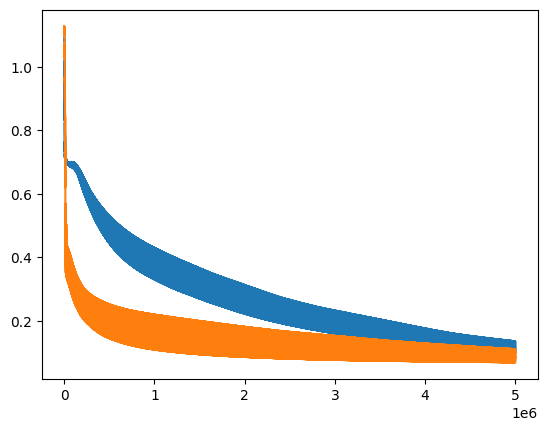

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
import numpy as np
from train_utils import *
import torch.nn.functional as F


device = torch.device('cuda')
batchsize = 100
#================================
# Quantization levels
#================================
img_half_level = 4
weight_bit = 8 
output_bit = 6
isint = 0
clamp_std = 0
noise_scale = 5e-2

def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader


def overlay_y_on_x(x, y):
    """
    Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_


class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]

    def predict(self, x): 
        # 这个predict方法是理解ff方法的关键，它不是像普通的predict方法一样，输入一个样本，输出一个长度为num_cls的softmax预测向量
        # 而是一个样本反复输入这个网络num_cls次，把每种带标签的可能都计算一个goodness，也就是这个数据是好数据的可能性，找出最高goodness的就是预测类别
        goodness_per_label = []
        for label in range(10): # 对每一个标签进行预测
            h = overlay_y_on_x(x, label) # h是输入x和标签label的叠加
            goodness = [] # goodness是一个列表，里面存放了每一层的结果向量的均方
            for layer in self.layers: # 对每一层进行前传
                h = layer(h) # h是每一层的输出
                goodness += [h.pow(2).mean(1)] # goodness是每一层的结果向量的均方。h.pow(2)是h的每一个元素的平方，mean(1)是对每一行求均值
            goodness_per_label += [sum(goodness).unsqueeze(1)] # goodness_per_label是每一层的结果向量的均方的和
        goodness_per_label = torch.cat(goodness_per_label, 1) # goodness_per_label是每一层的结果向量的均方的和的列表
        return goodness_per_label.argmax(1) # 返回的是goodness_per_label中每一行最大值的索引，也就是说，返回的是每一行最大值的列索引

    def train(self, li_epochs, li_lr): #, x_pos, x_neg): # 这个train方法是对整个网络进行训练，训练的目标是让正样本的结果向量的均方上升，负样本的结果向量的均方下降
        x, y = next(iter(train_loader))
        x, _ = my.data_quantization_sym(x, half_level=img_half_level)
        x, y = x.cuda(), y.cuda()
        x_pos = overlay_y_on_x(x, y)
        # rnd = torch.randperm(x.size(0)) # 生成一个从0到n-1的随机整数序列。
        # x_neg = overlay_y_on_x(x, y[rnd])
        y_rnd = y.clone()
        for i, y_i in enumerate(y):
            li = list(range(10))
            li.remove(y_i)
            j = np.random.choice(li)
            y_rnd[i] = j

        x_neg = overlay_y_on_x(x, y_rnd)

        h_pos, h_neg = x_pos, x_neg # h_pos和h_neg是正样本和负样本的输入
        for i, layer in enumerate(self.layers): # 对每一层进行训练
            print('training layer', i, '...') # 这里的i是层数
            h_pos, h_neg = layer.train(h_pos, h_neg, num_epochs=li_epochs[i], lr=li_lr[i]) # 对每一层进行训练，得到了正样本和负样本的结果向量，这个结果向量是该层的输出，也是下一层的输入
            # 也就是说，这个训练的过程中，正样本在前传过程中得到的每一层输出都被认为是正的，负样本在前传过程中得到的每一层输出都被认为是负的，也就是说，出身决定一切


class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=8e-3)
        self.threshold = 2.0
        # self.num_epochs = num_epochs # 训练的次数是1000次
        # self.linear = my.Linear_quant_noise(in_features, out_features, weight_bit=weight_bit, output_bit=output_bit, isint=isint, clamp_std=clamp_std, noise_scale=noise_scale, bias=True)
        self.weight_bit = weight_bit
        self.output_bit = output_bit
        self.isint = 0
        self.clamp_std = 0
        self.noise_scale = 0
        self.weight_half_level = 2 ** weight_bit / 2 - 1
        self.output_half_level = 2 ** output_bit / 2 - 1
        # self.linear = nn.Linear(in_features, out_features, bias=True)

        self.lossli = []

    def forward(self, x):
        # print("x.shape", x.shape)
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)  # 这个是对输入做了归一化，使得输入的模长为1，这在论文里有解释
        # print("x_norm.shape", x_direction.shape)
        # x_direction = x / x.max()
        self.weight_, self.bias_ = my.Weight_Quant_Noise.apply(self.weight, self.bias,
                                            self.weight_half_level, 
                                            self.isint, self.clamp_std,
                                            self.noise_scale
                                            )
        # self.weight_, self.bias_ = self.weight, self.bias
        x_direction = self.relu(
            # torch.mm(x_direction, self.weight.T) +
            # self.bias.unsqueeze(0) # 这个是对输入做了最基本的前向传播，得到了结果向量4
            # self.linear(x_direction)
            F.linear(x_direction, self.weight_, self.bias_)
            ) # 注意，在前传之后，随即使用了relu激活函数，这意味着每一层的所有激活值都是非负的
        
        x = my.Feature_Quant.apply(x, self.output_half_level, self.isint)
        # print("x_direction.shape", x_direction.shape)

        return x_direction

    def train(self, x_pos, x_neg, num_epochs=4000000, lr=8e-3):
        opt = Adam(self.parameters(), lr=lr)
        # 训练其实就是对每一层分别进行训练，训练的目标是让正样本的结果向量的均方上升，负样本的结果向量的均方下降
        # 每一层的forward方法定义如上一个函数，这里的train方法定义了训练的过程
        # print("x_pos.shape", x_pos.shape)
        for i in tqdm(range(num_epochs)):
            # minibatch
            bz = 100
            for j in range(0, x_pos.size(0), bz):
                
                # print(j)
                # mask = torch.randperm(x_pos.size(0))[j: j+bz]
                # mask = [j: j+bz]
                h_pos = x_pos[j: j+bz] # 随机采样1000个正样本
                h_neg = x_neg[j: j+bz] # 随机采样1000个负样本


                # for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
                #     visualize_sample(data, name)
                
                # print(self.forward(x_pos).pow(2), self.forward(x_pos).pow(2).shape)
                g_pos = self.forward(h_pos).pow(2).mean(1) # g_pos 是正样本x_pos在该层前向传播得到的结果向量的均方
                g_neg = self.forward(h_neg).pow(2).mean(1) # g_neg 是负样本x_neg在该层前向传播得到的结果向量的均方
                # 论文关于使用L2范数来度量的理由：
                # There are two main reasons for using the squared length of the activity vector as the goodness function.
                # First, it has very simple derivatives. Second, layer normalization removes all trace of the goodness.
                
                # The following loss pushes pos (neg) samples to
                # values larger (smaller) than the self.threshold.
                # 随着训练过程，loss下降，g_pos将上升，g_neg将下降
                loss = torch.log(1 + torch.exp(torch.cat([
                    -g_pos + self.threshold,
                    g_neg - self.threshold]))).mean() # loss = [log(1+exp(-(g_pos-threshold))) + log(1+exp(g_neg-threshold))] / 2
                # print(loss)
                self.lossli.append(loss.item())  # save loss
                
                # this backward just compute the derivative and hence
                # is not considered backpropagation.

                loss.backward()
                
                # self.opt.step()
                # self.opt.zero_grad()
                    
            # optimizer.step()
            # optimizer.zero_grad()
            # if i<4:
            #     # print(a)
            #     # 查看累积的梯度值
            #     # print(self.parameters())
            #     for param in self.parameters():
            #         print(param.grad)
                # print(loss)

            opt.step()
            opt.zero_grad()

            # 关于这里为什么能够work：
            # 1. loss是权重的函数，loss的核心思想是让g_pos上升，g_neg下降
            # 2. g_pos和g_neg是x_pos和x_neg的函数，x_pos和x_neg反映了客观世界，是这样要学习的对象。有了x_pos和x_neg，就能够计算出g_pos和g_neg，有了g_pos和g_neg，就能够计算出loss
            # 3. 通过loss.backward()，计算loss对权重的梯度，使得loss下降，g_pos上升，g_neg下降
            # 4. 通过self.opt.step()，更新了self.weight和self.bias
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

    
# def visualize_sample(data, name='', idx=0):
#     reshaped = data[idx].cpu().reshape(28, 28)
#     plt.figure(figsize = (4, 4))
#     plt.title(name)
#     plt.imshow(reshaped, cmap="gray")
#     plt.show()
    
    
if __name__ == "__main__":
    torch.manual_seed(1234)
    train_loader, test_loader = MNIST_loaders(train_batch_size=50000, test_batch_size=10000)

    net = Net([784, 500, 500])
    x, y = next(iter(train_loader))
    x, y = x.cuda(), y.cuda()
    # x_pos = overlay_y_on_x(x, y)
    # # rnd = torch.randperm(x.size(0)) # 生成一个从0到n-1的随机整数序列。
    # # x_neg = overlay_y_on_x(x, y[rnd])
    # y_rnd = y.clone()
    # for i, y_i in enumerate(y):
    #     li = list(range(10))
    #     li.remove(y_i)
    #     j = np.random.choice(li)
    #     y_rnd[i] = j

    # x_neg = overlay_y_on_x(x, y_rnd)
    # # for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
    # #     visualize_sample(data, name)
    
    net.train(li_epochs=[10000, 10000], li_lr=[8e-3, 8e-3])#x_pos, x_neg)

    print('train accu:', 100. * net.predict(x).eq(y).float().mean().item())

    x_te, y_te = next(iter(test_loader))
    x_te, y_te = x_te.cuda(), y_te.cuda()

    print('test accu:', 100. * net.predict(x_te).eq(y_te).float().mean().item())

    print(net.predict(x_te)[:30], y_te[:30])

    plt.plot(net.layers[0].lossli)
    plt.plot(net.layers[1].lossli)
    plt.show()
